# Урок 4. Алгоритм построения дерева решений

In [1]:
#Задание 1:
#В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков,
#глубина дерева и т. д.

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [211]:
#Часть кода, в который были внесены изменения

#Дерево решений говорит нам: пока я снижаю энтропию, я буду делать разбиение. Такое дерево решений получается переобученным,
#один из способов борьбы с переобученным деревом - это реализация критерия останова для остановки сплитования дерева.
#Используем один из следующие критериев останова (по сути все они об одном и том же - мы строим более простые деревья, дающие
#более устойчивый прогноз:
#1. leaf_counts - количество решающих листьев в дереве
#2. feature_counts - количество фичей, которые были использованы для сплитования
#3. depth - глубина


#В общем случае должно получится следующее:
# -- чем меньше глубина дерева, тем меньше переменных мы используем для прогноза. Используем только переменные с максимальной
# значимостью, дающие максимальный прирост информации;
# -- чем меньше количество листьев, тем более устойчив прогноз на тестовой выборке;

def build_tree_ostanova(data, labels):
    #вводим глобальную переменную глубина дерева depth
    global depth
    
    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
    #Увеличиваем глубину дерева на 1 после каждого сплитования
    depth += 1
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0 or depth > 10: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_ostanova(true_data, true_labels)
    false_branch = build_tree_ostanova(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

* [Дерево без критерия останова слишком переобучено: точность на тренировочной выборке = 100%, на тестовой 84.67%](#without)
* [Дерево с условием на глубину: точность на тренировочной выборке = 74%, на тестовой 69% .Алгоритм показывает более устойчивый 
   результат на тестовой выборке: разница между точностью на тренировочной - 5 процентных пункта](#withdepth)

In [154]:
# сгенерируем данные и посмотрим, как изменились гусочно-постоянные гипер-плоскости, которые строит дерево для разделения
#объектов на 2 группы

classification_data, classification_labels = datasets.make_classification(n_samples = 1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 4, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

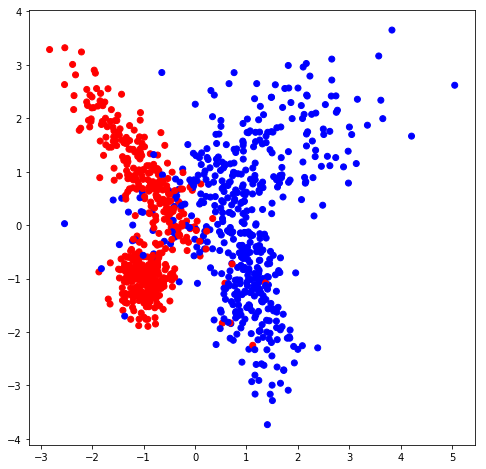

In [155]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [156]:
#Создаем базовый элемент узел:
# Реализуем класс решающего узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [157]:
# И класс терминального узла (листа) - ему не нужен сплит, но ему надо сказать, какое значение мы сопоставляет с этим листом
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

In [158]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

In [159]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [160]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [161]:
# Нахождение наилучшего разбиения - простой перебор по всем переменным и всем значениям, которые эти переменные принимают.
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение, закидываем
            #в сплит данные
            # пропускаем разбиения, в которых в узле остается менее 5 объектов
            # преодолеваем минимальный порог
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [162]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [163]:
# Проход объекта по дереву для его классификации
# obj - это объект, для которого нужно сделать предсказание
# node - это построенное дерево
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [164]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [165]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [203]:
# Построим дерево по обучающей выборке
depth = 0
my_tree = build_tree(train_data, train_labels)
my_tree_ostanova = build_tree_ostanova(train_data, train_labels)

In [204]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers_ostanova = predict(train_data, my_tree_ostanova)

In [205]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
answers_ostanova = predict(test_data, my_tree_ostanova)

In [206]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [207]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy_ostanova = accuracy_metric(train_labels, train_answers_ostanova)

In [208]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy_ostanova = accuracy_metric(test_labels, answers_ostanova)

#### Переобученное дерево <a class='anchor' id='without'>

Text(0.5,1,'Test accuracy=84.67')

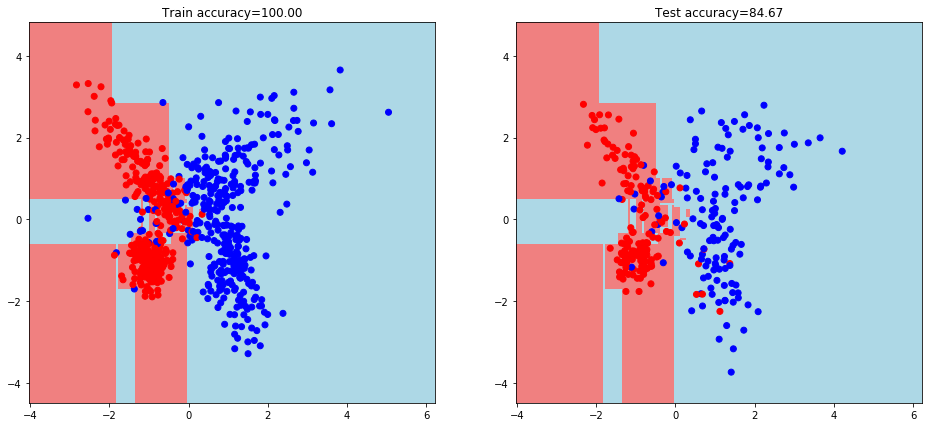

In [209]:
# Визуализируем дерево на графике

#в рамках заданного диапазона создаем сетку, отправили их в predict. В predict должен попадать вектор из двух агрументов.
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### Дерево с уловием на глубину <a class='anchor' id='withdepth'>

Text(0.5,1,'Test accuracy=69.00')

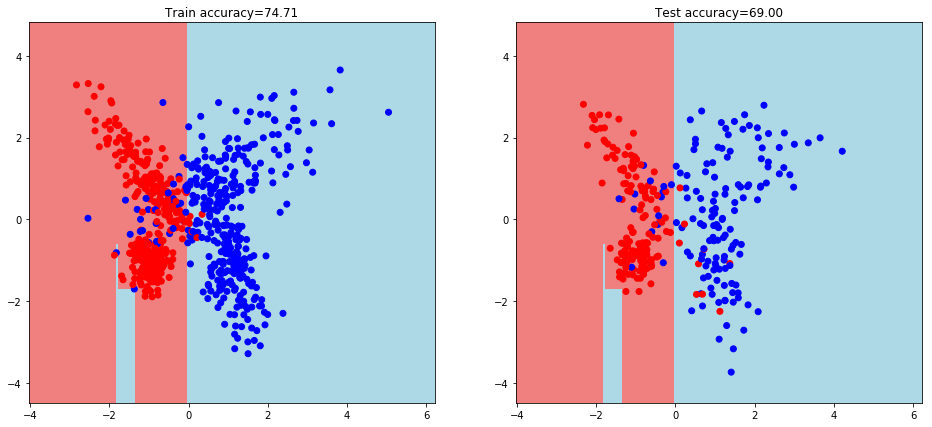

In [210]:
# Визуализируем дерево c критерием останова на графике

#в рамках заданного диапазона создаем сетку, отправили их в predict. В predict должен попадать вектор из двух агрументов.
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_ostanova)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_ostanova:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_ostanova:.2f}')

In [95]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print('Выведем значение индекса и порога на этом узле \n')
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree_ostanova)

Выведем значение индекса и порога на этом узле 

Индекс 0
Порог -0.06941331072338452
--> True:
Выведем значение индекса и порога на этом узле 

  Индекс 1
  Порог -0.3382349186758744
  --> True:
Выведем значение индекса и порога на этом узле 

    Индекс 1
    Порог -0.5948838228187372
    --> True:
Выведем значение индекса и порога на этом узле 

      Индекс 0
      Порог -1.3687153893767392
      --> True:
Выведем значение индекса и порога на этом узле 

        Индекс 0
        Порог -1.415670659755537
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
Выведем значение индекса и порога на этом узле 

      Индекс 1
      Порог -0.5367633982219875
      --> True:
        Прогноз: 0
      --> False:
Выведем значение индекса и порога на этом узле 

        Индекс 1
        Порог -0.47519639119582013
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
  --> False:
Выведем значение 

In [96]:
#Задание 2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм
#предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [125]:
data, y = datasets.make_regression(n_samples = 1000, n_features = 2, n_informative = 2, 
                                        random_state=5)

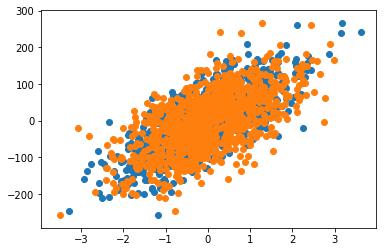

In [126]:
plt.scatter(data[:,0], labels)
plt.scatter(data[:,1], labels)

In [100]:
# И класс терминального узла (листа) - ему не нужен сплит, но ему надо сказать, какое значение мы сопоставляет с этим листом
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # посчитаем среднее значение по выборке
        prediction = np.mean(data)
        return prediction

In [144]:
# Для каждой итерации по признаку и по пороговому значению признака, мы должны рассчитать критерий Джини, как дисперсию значений:
#true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # сделали разбиение

# Расчет критерия Джини
def gini_for_regression(labels):
    impurity = np.mean((labels - labels.mean())**2)
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества